## 일반화 성능

### 1. 환경준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')

### 2. 데이터 준비

* 변수설명
    * COLLEGE : 대학 졸업여부
    * INCOME : 연수입
    * OVERAGE : 월평균 초과사용 시간(분)
    * LEFTOVER : 월평균 잔여시간비율(%)
    * HOUSE : 집값
    * HANDSET_PRICE : 스마트폰 가격
    * OVER_15MINS_CALLS_PER_MONTH : 월평균 장기통화(15분이상) 횟수
    * AVERAGE_CALL_DURATION : 평균 통화 시간
    * REPORTED_SATISFACTION : 만족도 설문조사 결과
    * REPORTED_USAGE_LEVEL : 사용도 자가진단 결과
    * CONSIDERING_CHANGE_OF_PLAN : 향후 변경계획 설문조사 결과
    * CHURN : 이탈(번호이동) 여부 (1-이탈, 0-잔류, Target 변수)

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(1000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
3178,3179,0,119512,51,31,248566,229,5,2,very_sat,very_high,considering,1
14926,14927,1,142144,192,15,774317,581,29,4,unsat,very_little,never_thought,1
15116,15117,1,142308,0,79,306426,497,1,1,sat,little,considering,0
12733,12734,1,113385,0,0,333599,819,1,6,very_unsat,very_high,considering,1
14032,14033,1,90348,209,10,637286,360,26,4,unsat,little,actively_looking_into_it,0


In [3]:
# id drop
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True)

In [4]:
# x, y 나누기
target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [ ]:
# NA 조치

In [5]:
# 가변수화
cat_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns=cat_cols, drop_first=True)

### 3. Random Sampling

- 데이터를 랜덤으로 분할해 모델링 & 예측을 여러번 반복적으로 수행

In [7]:
# 아래 셀을 반복 실행
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

# DecisionTree 모델링
model = DecisionTreeClassifier(max_depth = 3)
model.fit(x_train, y_train)
pred = model.predict(x_val)
accuracy_score(y_val, pred)

0.67

- accuracy 값이 달라짐을 볼 수 있음.
- 값이 달라진다면 모델의 성능을 어떻게 신뢰할 수 있는지?

In [8]:
# 여러번 반복해 평균을 계산하기
result = []
for i in range(100):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)
    model = DecisionTreeClassifier(max_depth = 3)
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    result.append(accuracy_score(y_val, pred))

In [9]:
# 평균과 표준편차
np.mean(result), np.std(result)

(0.6812000000000001, 0.029130053209700787)

mean: 0.6812000000000001 ,  std: 0.029130053209700787


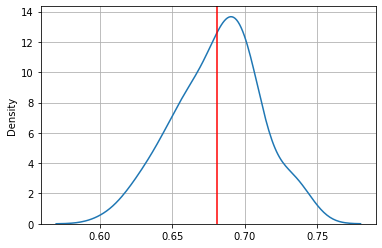

In [10]:
# 값의 분포
print('mean:', np.mean(result), ',  std:', np.std(result))
sns.kdeplot(result)
plt.axvline(np.mean(result), color='r')
plt.grid()
plt.show()

- 정규분포에 근사

### 4. k-fold Cross Validation

In [11]:
#  cross_val_score 함수
from sklearn.model_selection import cross_val_score

In [12]:
# 학습 및 검증
model = DecisionTreeClassifier(max_depth=3)

- cross_val_score(모델, x, y, cv)
    - 여기서 x, y는 train+val

In [13]:
# train + validation set을 이용하여 학습, 예측, 평가를 한번에. (여기서는 .fit 이 아님)
dt_result = cross_val_score(model, x, y, cv=10)
print(dt_result)
print(dt_result.mean(), dt_result.std())

[0.66 0.73 0.64 0.68 0.66 0.72 0.63 0.69 0.61 0.73]
0.675 0.040311288741492736


In [14]:
# knn을 이용해 kfold수행

# 스케일링
scaler = MinMaxScaler()
x = scaler.fit_transform(x) # train, val이 합쳐져있으니 따로 나누지 않음

In [15]:
# 학습
model_knn = KNeighborsClassifier()

In [16]:
knn_result = cross_val_score(model_knn, x, y, cv=10)
print(knn_result)
print(knn_result.mean(), knn_result.std())

[0.58 0.59 0.62 0.59 0.52 0.58 0.57 0.63 0.54 0.59]
0.581 0.03112876483254675


### 5. 데이터 늘리기 (Learning Curve)

In [17]:
# 데이터 준비 (이번에는 4000행)
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(4000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})

In [18]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

In [19]:
# learning_curve 함수
from sklearn.model_selection import learning_curve

In [20]:
# 데이터 양에 따른 성능 측정
model = DecisionTreeClassifier(max_depth=3)

In [21]:
x.shape[0]

4000

#### learning_curve 함수

- Input
    - 모델 x, y
    - train_sizes : 순차적으로 학습시킬 data size의 list

- Output
    - tr_size : Input에서 지정한 값 list (train_sizes)
    - tr_scores : 학습용 데이터에서의 성능
    - val_scores : valid 성능

In [22]:
tr_size, tr_scores, val_scores = learning_curve(model, 
                                                x, y, 
                                                train_sizes = range(5, 3200, 10),
                                                cv = 10)

In [23]:
val_scores[:5]

array([[0.4875, 0.5175, 0.495 , 0.4575, 0.5125, 0.4775, 0.4825, 0.49  ,
        0.5225, 0.4975],
       [0.615 , 0.47  , 0.4775, 0.46  , 0.42  , 0.4725, 0.4875, 0.4175,
        0.425 , 0.49  ],
       [0.5175, 0.5825, 0.54  , 0.5075, 0.575 , 0.545 , 0.5475, 0.5875,
        0.58  , 0.545 ],
       [0.61  , 0.565 , 0.5775, 0.525 , 0.545 , 0.58  , 0.565 , 0.5675,
        0.5675, 0.6   ],
       [0.6075, 0.6075, 0.5425, 0.5275, 0.5325, 0.5925, 0.6225, 0.555 ,
        0.605 , 0.56  ]])

In [26]:
# cv 결과를 평균으로 집계
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

### 성능 평가 : Bias가 줄어드는가?

- 데이터가 적으면 variance가 많다.
- 데이터가 많아질수록 variance가 줄어든다.
- Bias가 줄어드는가? (성능이 향상되는가?)

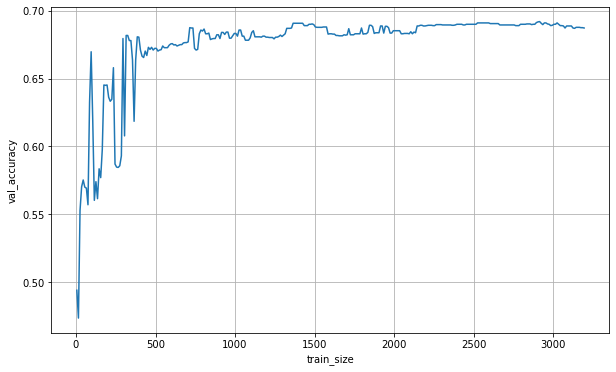

In [27]:
plt.figure(figsize = (10,6))
plt.plot(tr_size, val_scores_mean)

plt.ylabel('val_accuracy')
plt.xlabel('train_size')
plt.grid()
plt.show()

### 성능 평가 : Variance가 줄어드는가?

- Variance가 줄어드는가? (성능의 편차가 줄어드는가?)

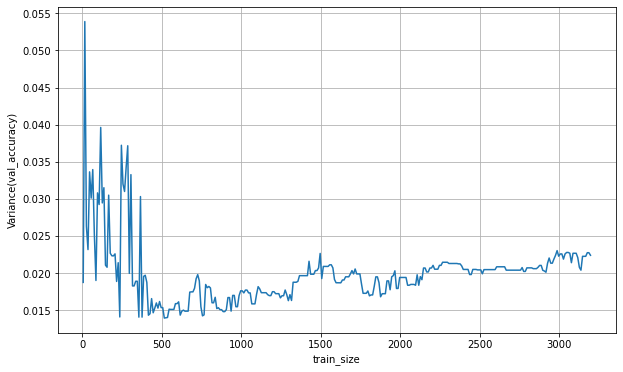

In [28]:
plt.figure(figsize = (10,6))
plt.plot(tr_size, val_scores_std)

plt.ylabel('Variance(val_accuracy)')
plt.xlabel('train_size')
plt.grid()
plt.show()